In [206]:
# Standard library imports
#https://github.com/analyticsindiamagazine/MachineHack
import gc
import math
import re

# Third-party imports
import lightgbm as lgb
import pandas as pd
import numpy as np
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, BayesianRidge
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy import sparse
import scipy

# Jupyter notebook magic command
%matplotlib inline

# Additional setup
stopwords1 = set(STOPWORDS)


In [207]:
def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords1,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')

    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [208]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
sample = pd.read_csv("Sample Submission.csv")

print(train.shape, test.shape, sample.shape)

(5429, 9) (2327, 8) (2327, 1)


## Feature Engineering

In [209]:
## Feature Engineering
dataset = pd.concat([train, test])
dataset.reset_index(drop=True)
dataset = dataset.sort_values(by=['session_id'])
dataset["client_agent_length"] = dataset["client_agent"].str.len()
dataset["client_agent_semicolon_count"] = dataset["client_agent"].str.count(";")
dataset["client_agent_version_count"] = dataset["client_agent"].str.count("/")
dataset["browser_version"] = dataset["client_agent"].str.split("/",expand=True)[1].str.split(" ",expand=True)[0]
dataset [["device","browser"]] = dataset["device_details"].str.split(pat=" - ",expand=True)

handheld = [int(device in ["iPhone","Android Phone","Android Tablet","iPad"]) for device in dataset ["device"]]
dataset ["hand_held"] = pd.Series(handheld)

desktop = [int(i == "Desktop") for i in dataset ["device"]]
dataset ["desktop"] = pd.Series(desktop)

others = [int(i in ["Other","Unknown"]) for i in dataset["device"]]
dataset["others"] = pd.Series(others)
dataset["overallScore"] = dataset["purchased"]*0.9820073158772702 + dataset["added_in_cart"]*1 + dataset["checked_out"]*1.816082409501863

dataset['date']= pd.to_datetime(dataset['date'])

dataset["month"] = dataset['date'].dt.month
dataset["year"] = dataset['date'].dt.year
dataset["week"] = dataset['date'].dt.isocalendar().week
dataset["dayOfWeek"] = dataset['date'].dt.dayofweek
dataset["day"] = dataset["date"].dt.day

dataset["dailyTraffic"] = dataset.groupby("date")["session_id"].transform("count")
dataset["dailyTrafficPerDevice"] = dataset.groupby(["date","device"])["session_id"].transform("count")
dataset["dailyTrafficPerbrowser"] = dataset.groupby(["date","browser"])["session_id"].transform("count")

dataset["device_num"] = dataset["device"].replace({
    "Other": 1,
    "Unknown": 1, 
    "Android Tablet":2,
    "iPhone":3,
    "Android Phone":4,
    "iPad":5, "Desktop":5
})
dataset.head()


/tmp/ipykernel_9041/3736111079.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["device_num"] = dataset["device"].replace({


,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent,client_agent_length,...,overallScore,month,year,week,dayOfWeek,day,dailyTraffic,dailyTrafficPerDevice,dailyTrafficPerbrowser,device_num
3696,0000ccfee64caa1d4ac5e2c025183bd5,77,Product/4.2.2 iPhone/7.1.2,iPhone - iOS,2019-10-07,1,0,0,175.537,26.0,...,0.982007,10,2019,41,0,7,22,11,9,3
111,0001351371faa5a11668bd7e595d718b,33,Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7....,Desktop - IE,2020-02-28,1,0,0,849.612,68.0,...,0.982007,2,2020,9,4,28,17,8,2,5
2777,00061e9b19af901ed6172af75447e0fe,220,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,Desktop - Chrome,2020-02-22,0,0,0,40.830,102.0,...,0.000000,2,2020,8,5,22,26,11,7,5
504,0007570f57deb464f48e062d9751cb95,3344,Product/4.7.0 iPhone/8.1,iPhone - iOS,2019-12-26,0,1,0,NaN,24.0,...,1.000000,12,2019,52,3,26,29,22,14,3
5204,0007799644b7b1eec55a6390deda8065,143,Product/4.1.1 iPhone/7.1.2,iPhone - iOS,2019-08-11,0,0,0,1046.787,26.0,...,0.000000,8,2019,32,6,11,30,12,6,3


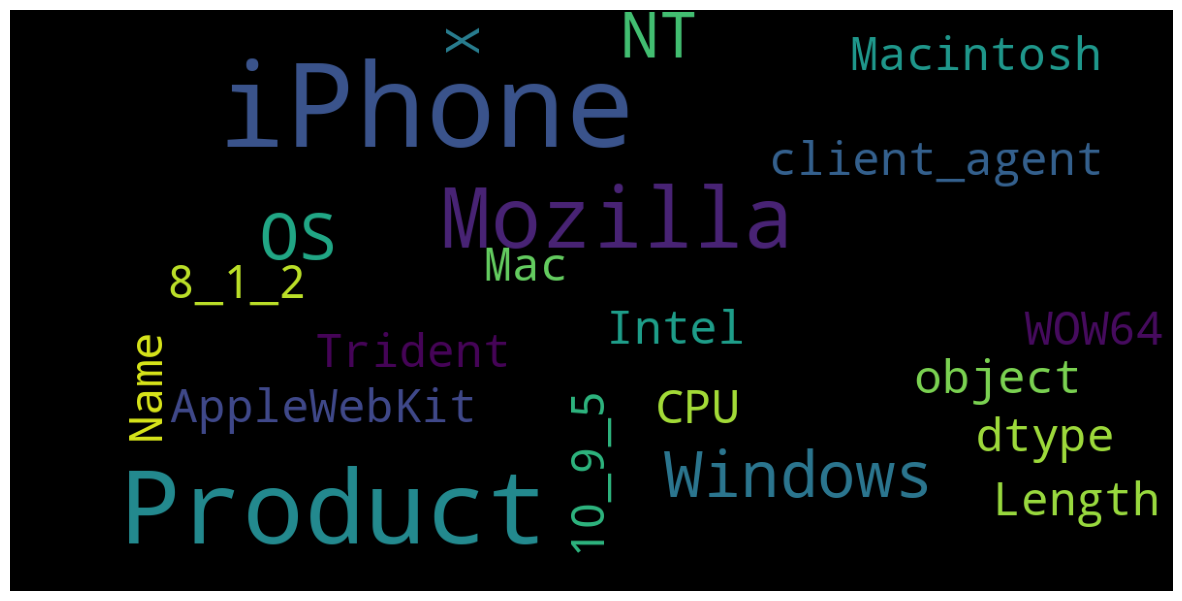

In [210]:
show_wordcloud(dataset['client_agent'])

In [211]:
dataset.isnull().sum()

session_id                         0
session_number                     0
client_agent                     219
device_details                     0
date                               0
purchased                          0
added_in_cart                      0
checked_out                        0
time_spent                      2327
client_agent_length              219
client_agent_semicolon_count     219
client_agent_version_count       219
browser_version                  229
device                             0
browser                            0
hand_held                          0
desktop                            0
others                             0
overallScore                       0
month                              0
year                               0
week                               0
dayOfWeek                          0
day                                0
dailyTraffic                       0
dailyTrafficPerDevice              0
dailyTrafficPerbrowser             0
d

In [212]:
dataset["client_agent"] = dataset["client_agent"].fillna('n/a')
dataset["client_agent_length"] = dataset["client_agent_length"].fillna(0)
dataset["client_agent_semicolon_count"] = dataset["client_agent_semicolon_count"].fillna(0)
dataset["client_agent_version_count"] = dataset["client_agent_version_count"].fillna(0)
dataset["browser_version"] = dataset["browser_version"].fillna('n/a')


In [213]:
dataset.isnull().sum()

session_id                         0
session_number                     0
client_agent                       0
device_details                     0
date                               0
purchased                          0
added_in_cart                      0
checked_out                        0
time_spent                      2327
client_agent_length                0
client_agent_semicolon_count       0
client_agent_version_count         0
browser_version                    0
device                             0
browser                            0
hand_held                          0
desktop                            0
others                             0
overallScore                       0
month                              0
year                               0
week                               0
dayOfWeek                          0
day                                0
dailyTraffic                       0
dailyTrafficPerDevice              0
dailyTrafficPerbrowser             0
d

In [214]:
dataset.isnull().sum()

session_id                         0
session_number                     0
client_agent                       0
device_details                     0
date                               0
purchased                          0
added_in_cart                      0
checked_out                        0
time_spent                      2327
client_agent_length                0
client_agent_semicolon_count       0
client_agent_version_count         0
browser_version                    0
device                             0
browser                            0
hand_held                          0
desktop                            0
others                             0
overallScore                       0
month                              0
year                               0
week                               0
dayOfWeek                          0
day                                0
dailyTraffic                       0
dailyTrafficPerDevice              0
dailyTrafficPerbrowser             0
d

In [215]:
dataset_numeric = dataset.select_dtypes(include=[float, int])
corr_matrix = dataset_numeric.corr().style.background_gradient(cmap='coolwarm')
corr_matrix

,session_number,purchased,added_in_cart,checked_out,time_spent,client_agent_length,client_agent_semicolon_count,client_agent_version_count,hand_held,desktop,others,overallScore,month,year,dayOfWeek,day,dailyTraffic,dailyTrafficPerDevice,dailyTrafficPerbrowser,device_num
session_number,1.000000,-0.219457,0.004128,-0.062982,0.078437,-0.165386,-0.064838,-0.223878,0.006321,-0.002681,-0.008285,-0.145082,0.074655,0.010379,0.006846,0.011354,0.233520,0.360082,0.281476,-0.261315
purchased,-0.219457,1.000000,0.044784,0.176573,0.200762,0.058624,0.008766,0.069010,0.008998,-0.002465,-0.014690,0.655528,-0.052782,0.057537,-0.005721,-0.015375,-0.072491,-0.116730,-0.101803,0.272977
added_in_cart,0.004128,0.044784,1.000000,0.213134,0.209807,-0.022542,0.061586,-0.014826,-0.010206,0.015941,-0.011479,0.686999,-0.043921,0.050055,-0.036994,0.009440,-0.020105,-0.052343,-0.008336,0.122896
checked_out,-0.062982,0.176573,0.213134,1.000000,0.157765,0.039280,0.009152,0.030195,-0.008732,0.015537,-0.013885,0.607178,-0.009714,0.013095,0.002739,-0.003550,0.002734,-0.019611,-0.026521,0.108779
time_spent,0.078437,0.200762,0.209807,0.157765,1.000000,-0.025433,-0.032025,-0.002716,0.017945,-0.012565,-0.012850,0.295618,0.013367,-0.030843,0.000285,-0.030206,0.070030,0.110008,0.075365,0.069221
client_agent_length,-0.165386,0.058624,-0.022542,0.039280,-0.025433,1.000000,0.487803,0.805970,0.006394,-0.006379,-0.000532,0.034955,0.021760,0.020808,0.011551,-0.000117,-0.038244,-0.137149,-0.267861,0.488898
client_agent_semicolon_count,-0.064838,0.008766,0.061586,0.009152,-0.032025,0.487803,1.000000,0.240019,0.001826,0.004459,-0.013598,0.044157,-0.025034,0.014729,0.008510,0.032465,-0.065582,-0.167893,-0.214668,0.179135
client_agent_version_count,-0.223878,0.069010,-0.014826,0.030195,-0.002716,0.805970,0.240019,1.000000,-0.003170,-0.002887,0.013214,0.041770,-0.012701,0.066701,-0.001999,-0.015227,-0.039320,-0.183889,-0.218464,0.440171
hand_held,0.006321,0.008998,-0.010206,-0.008732,0.017945,0.006394,0.001826,-0.003170,1.000000,-0.895392,-0.302126,-0.004221,0.011194,-0.011650,0.008872,-0.012981,-0.006452,-0.001978,-0.002569,0.002687
desktop,-0.002681,-0.002465,0.015941,0.015537,-0.012565,-0.006379,0.004459,-0.002887,-0.895392,1.000000,-0.153950,0.013832,-0.010776,0.009417,-0.006770,0.015874,0.006167,0.002493,0.007407,0.006599


In [216]:
dataset=pd.get_dummies(dataset,columns=['device_num','browser_version'],drop_first=True)
dataset.head()

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent,client_agent_length,...,browser_version_4.6.0,browser_version_4.7.0,browser_version_5.0,browser_version_6.0,browser_version_6533.21.1,browser_version_7.0,browser_version_8.0,browser_version_9.0,browser_version_9.80,browser_version_n/a
3696,0000ccfee64caa1d4ac5e2c025183bd5,77,Product/4.2.2 iPhone/7.1.2,iPhone - iOS,2019-10-07,1,0,0,175.537,26.0,...,False,False,False,False,False,False,False,False,False,False
111,0001351371faa5a11668bd7e595d718b,33,Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7....,Desktop - IE,2020-02-28,1,0,0,849.612,68.0,...,False,False,True,False,False,False,False,False,False,False
2777,00061e9b19af901ed6172af75447e0fe,220,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,Desktop - Chrome,2020-02-22,0,0,0,40.830,102.0,...,False,False,True,False,False,False,False,False,False,False
504,0007570f57deb464f48e062d9751cb95,3344,Product/4.7.0 iPhone/8.1,iPhone - iOS,2019-12-26,0,1,0,NaN,24.0,...,False,True,False,False,False,False,False,False,False,False
5204,0007799644b7b1eec55a6390deda8065,143,Product/4.1.1 iPhone/7.1.2,iPhone - iOS,2019-08-11,0,0,0,1046.787,26.0,...,False,False,False,False,False,False,False,False,False,False


In [217]:
fin_features = list(set(dataset.columns) - set(["session_id","client_agent","date","device","browser","device_details","time_spent","index"]))
fin_features

['desktop',
 'browser_version_160326',
 'browser_version_4.2.2',
 'client_agent_length',
 'client_agent_version_count',
 'browser_version_160330',
 'browser_version_160379',
 'browser_version_8.0',
 'browser_version_245',
 'year',
 'browser_version_4.2.0',
 'browser_version_4.5.0',
 'browser_version_3.6.0',
 'browser_version_160387',
 'browser_version_2.5.1',
 'browser_version_3.5.1',
 'browser_version_4.7.0',
 'browser_version_5.0',
 'browser_version_252',
 'browser_version_160360',
 'browser_version_150282',
 'browser_version_3.4.0',
 'day',
 'browser_version_160341',
 'browser_version_160406',
 'browser_version_160346',
 'browser_version_160355',
 'browser_version_244',
 'browser_version_4.3.3',
 'session_number',
 'browser_version_160447',
 'browser_version_160309',
 'browser_version_160432',
 'checked_out',
 'browser_version_160318',
 'browser_version_319',
 'browser_version_160382',
 'browser_version_2.1.0',
 'browser_version_6.0',
 'browser_version_160391',
 'browser_version_9.0

In [218]:
dftrain, dftest  = dataset[dataset["time_spent"].isnull()==False], dataset[dataset["time_spent"].isnull()==True]
dftest.reset_index(drop=True, inplace=True)
target = np.log1p(dftrain['time_spent'])
target

3696    5.173530
111     6.745956
2777    3.733614
5204    6.954436
1702    4.048318
          ...   
4260    6.018885
19      3.111380
1896    4.431543
4702    3.138836
1539    6.278103
Name: time_spent, Length: 5429, dtype: float64

In [219]:
v_1 = TfidfVectorizer(ngram_range=(1,3),stop_words="english", analyzer='word')
typ_tr =v_1.fit_transform(dftrain['client_agent'])
typ_ts =v_1.transform(dftest['client_agent'])


v_1c = TfidfVectorizer(ngram_range=(2,6),stop_words="english", analyzer='char')
typ_trc =v_1c.fit_transform(dftrain['client_agent'])
typ_tsc =v_1c.transform(dftest['client_agent'])

/home/fuad/playground/ml-dl-cnn-practice/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:543: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
